In [90]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_iters, plot_coverage_all, plot_contours_line, create_contours
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":20,
    "font.family": "serif"
})

In [91]:
seed = 15
np.random.seed(seed)
n = 2 # number of time periods
theta = 0.01

#initialize problem
cost = np.array([1.0, 100.0])/1000
P = 50 # np.full(n, 567) # max production capacity at each time period
Q = 300 # max production capacity for all periods
V_min = 50 # minimum inventory
V_max = 400 # maximum inventory
V_1 = 300 # initial inventory
V_2 = 250
test_p = 0.2
s = 5
d_hat = np.array([190, 160]) # nominal demand
data1 = d_hat * np.random.uniform(1-theta, 1+theta, (100, n))
d_hat2 = np.array([160, 120]) # nominal demand
data2 = d_hat2* np.random.uniform(1-theta, 1+theta, (100, n))
data = np.vstack([data1,data2])

train, test = train_test_split(data, test_size=int(
    data.shape[0]*test_p), random_state=s)

y_data = np.array([1, V_1])
y_data = np.tile(y_data, (100, 1))
y_data2 = np.tile(np.array([2, V_2]), (100, 1))
y_data = np.vstack([y_data, y_data2])

# calculate the best weights
set2 = np.hstack([5*sc.linalg.sqrtm(np.cov(data2.T)).flatten(),np.mean(data2,axis=0)])
set1 = np.hstack([5*sc.linalg.sqrtm(np.cov(data1.T)).flatten(),np.mean(data1,axis=0)])
W_found = cp.Variable((6,2))
b_found  = cp.Variable(6)
slack = cp.Variable(6)
objective = cp.Minimize(cp.norm(W_found)+ cp.norm(b_found))
constraints = [W_found @ y_data[0] + b_found == set1]
constraints += [W_found @ y_data[100] + b_found == set2]
prob = cp.Problem(objective, constraints)
prob.solve()
print(prob.objective.value,W_found.value, b_found.value)

y = lropt.Parameter(2, data = y_data)
u = lropt.UncertainParameter(2, uncertainty_set=lropt.Ellipsoidal(data=data, rho=1, p=2))
x = cp.Variable(2)
objective = cp.Minimize(x @ cost)
constraints = [cp.sum(x) <= Q, x >= 0]
b = {}
maxcons = []
for t in range(n): # for n = 2: one constraint for time t, one constrant for time t and t+1
    b[t] = np.concatenate((np.ones(t+1), np.zeros(n-t-1)))
    maxcons.append(-y @ np.array([0, 1]) - x @ b[t] + u @ b[t] + V_min) # V_min)
    maxcons.append(y @ np.array([0, 1]) + x @ b[t] - u @ b[t] - V_max)
constraints.append(cp.maximum(*maxcons)<=0)
prob = lropt.RobustProblem(objective, constraints)

11.362840573631642 [[-1.84987768e-01  2.01198418e-02]
 [-2.18587300e-01  1.16173526e-03]
 [-2.18587300e-01  1.16173526e-03]
 [-2.49375457e-02  1.47414119e-02]
 [ 1.47058702e+00  6.28283953e-01]
 [-1.12510284e+01  5.70422937e-01]] [-4.96552333e-10 -1.82139303e-10 -1.82181651e-10 -2.82172301e-10
 -1.01562125e-08 -1.85122714e-08]


In [92]:
init = 10*sc.linalg.sqrtm(np.cov(data.T))
# init = (100*np.eye(n) + 30*sc.linalg.sqrtm(np.cov(train.T)))*5
# init_bval = np.zeros(n)
#init = 300*sc.linalg.sqrtm(np.cov(train.T))
init_bval = np.mean(data, axis=0)
# np.random.seed(15)
# initn = np.random.rand(n,2)
# Train A and b
result = prob.train(lr=0.0001, train_size = False, num_iter=500, optimizer="SGD",seed=1, init_A=init, init_b=init_bval, init_lam=1, init_mu=1,
                    mu_multiplier=1.001, kappa=0., init_alpha=0., test_percentage = test_p,save_history = True, quantiles = (0.4,0.6), lr_step_size = 50, lr_gamma = 0.3, random_init = False, num_random_init = 1, parallel = False, position = False, eta=0.05,contextual = True, init_weight = W_found.value, init_bias = b_found.value)
df = result.df
A_fin = result.A
b_fin = result.b

In [108]:
x = cp.Variable(2)
objective = cp.Minimize(-2*x[0]-1*x[1])
constraints = [x >= 0, -3*x[0] + 1*x[1] <= 1, 2*x[0]+1*x[1]<=6 ]
prob = cp.Problem(objective,constraints)
prob.solve()
print(x.value, constraints[1].dual_value, constraints[2].dual_value, constraints[0].dual_value, prob.objective.value)

[1.29669743 3.40660512] 1.4964279476743012e-09 1.0000000006265564 [1.9327376e-09 8.2193255e-10] -5.999999988246564


In [51]:
# Grid search epsilon
eps_list = np.linspace(0.01, 5, 30)
lin_model = torch.nn.Linear(in_features = 2,
                                out_features = 6).double()
lin_model.weight.data = torch.tensor(W_found.value
                    , dtype=torch.double,requires_grad=True)
lin_model.bias.data = torch.tensor(b_found.value
                    , dtype=torch.double,requires_grad=True)
# result4 = prob.grid(epslst=eps_list, init_A=init,
#                     init_b=init_bval, seed=8,
#                     init_alpha=0., test_percentage=test_p, quantiles = (0.4, 0.6))
# dfgrid = result4.df
# result_mv = prob.grid(epslst=eps_list, init_eps = 1, init_A=None,
#                     init_b=None, seed=8,
#                     init_alpha=0., test_percentage=test_p, quantiles = (0.4, 0.6), contextual = True, linear = lin_model)
# dfgrid1 = result_mv.df

result5 = prob.grid(epslst=eps_list, init_eps = result.eps, init_A=None, init_b=None, seed=8,init_alpha=0., test_percentage=test_p,quantiles = (0.4,0.6), contextual = True, linear = result._linear)
dfgrid2 = result5.df

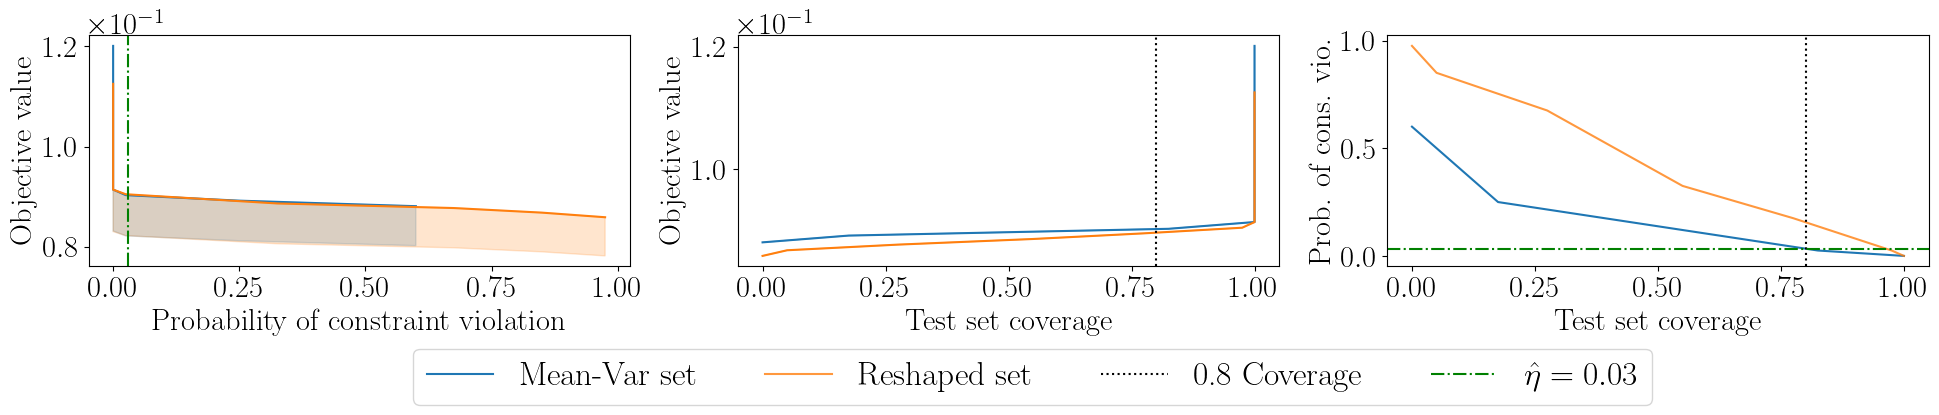

In [104]:
plot_coverage_all(dfgrid1,dfgrid2,None, "inv",ind_1=(0,30),ind_2=(0,30), logscale = False, zoom = False,legend = True)

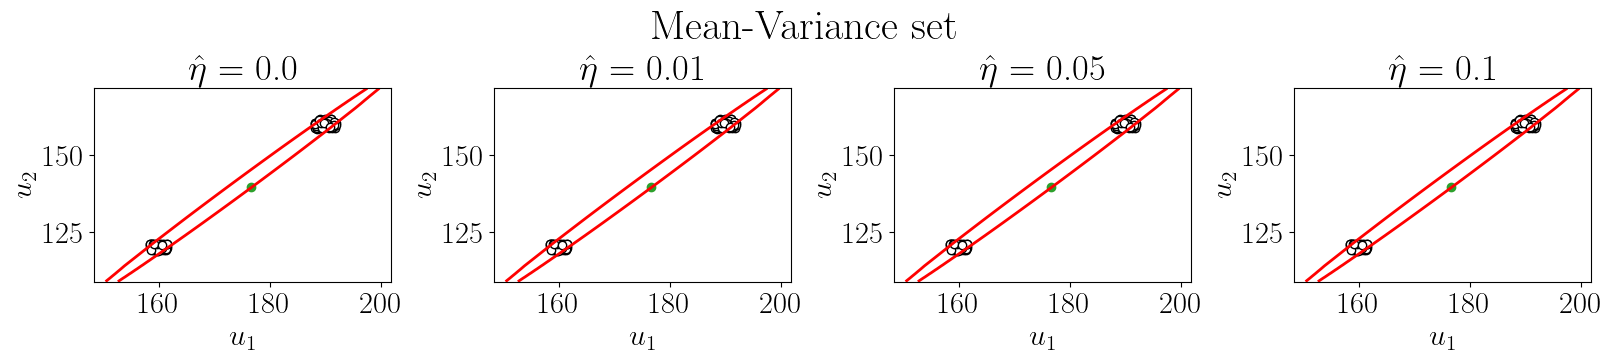

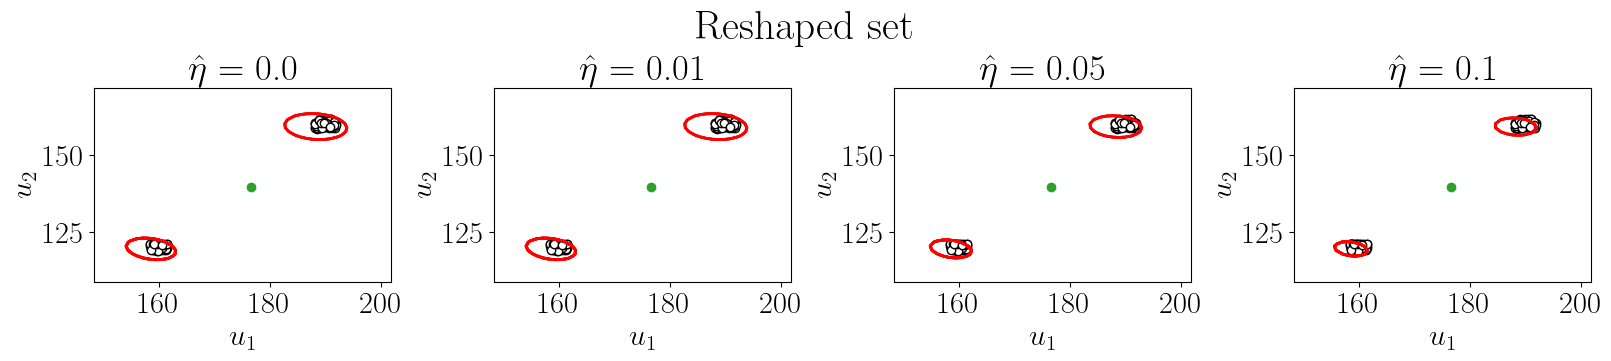

In [94]:
# init = 100*np.eye(2)
K = 8
Amat = result._a_history[-1]*result.eps
bvec = result._b_history[-1]
x,y, fin_set, init_set, inds_reshaped, inds_standard,prob_list = create_contours(Amat, bvec,init, init_bval,eps_list, train,test,dfgrid,dfgrid2, K, offset=10)
plot_contours_line(x,y,init_set, None,prob_list,4,train,test, "port_intro_new",standard = True, K=1) 
plot_contours_line(x,y,fin_set, None,prob_list,4,train,test, "port_intro_new",standard = False, K=K)

## Plot uncertainty sets together

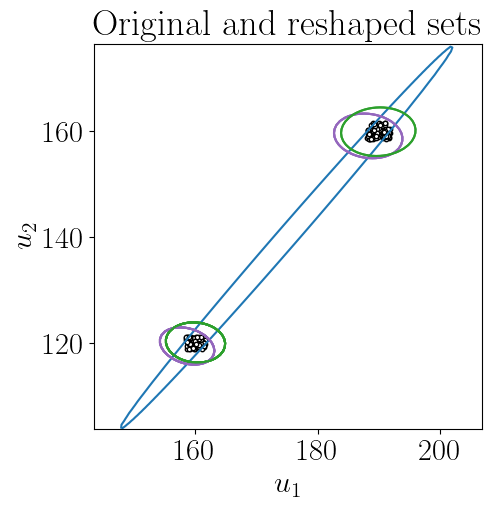

In [54]:
st_eps = eps_list[inds_standard[0]]
re_eps = eps_list[inds_reshaped[0]]
offset = 15
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
n_points = 100
X = np.linspace(x_min,x_max,n_points)
Y = np.linspace(y_min,y_max,n_points)
x_mesh,y_mesh = np.meshgrid(X,Y)
A1_iters, b1_iters = result.uncset_iters
eps_iters = result._eps_history

def level_set(A_final, b_final, offset = 2, n = n_points, x_mesh = x_mesh, y_mesh = y_mesh, contextual = False):
    if not contextual:
        unc_level_set = np.zeros((n,n))
    else:
        unc_level_set = np.zeros((K,n,n))
    for i in range(n):
        for j in range(n):
            u_vec = [x_mesh[i,j], y_mesh[i,j]]
            for scene in range(K):
                if contextual:
                    unc_level_set[scene,i,j] = np.linalg.norm((A_final[scene].T@np.linalg.inv(A_final[scene]@A_final[scene].T)) @ (u_vec  - b_final[scene]))
                else:
                    unc_level_set[i,j] = np.linalg.norm((A_final.T@np.linalg.inv(A_final@A_final.T)) @ (u_vec  - b_final))

    return unc_level_set

unc_level_learned= level_set(A1_iters[-1]*re_eps*eps_iters[-1], b1_iters[-1], contextual = True)
unc_level = level_set(A1_iters[1]*eps_iters[1]*re_eps, b1_iters[1], contextual = True)
unc_level_base = level_set(init*st_eps, init_bval, contextual = False)

plt.figure(figsize=(5, 5))
plt.title("Original and reshaped sets")
# Set axis label for the contour plot
plt.xlabel(r"$u_1$")
plt.ylabel(r"$u_2$")

plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"]) #label = "MV Set"
for scene in range(K):
    plt.contour(x_mesh,y_mesh,unc_level_learned[scene,:,:], [1], colors = ["tab:purple"]) #, label = "Final Set"
    plt.contour(x_mesh,y_mesh,unc_level[scene,:,:], [1], colors = ["tab:green"]) #, label = "Initial Set"
plt.scatter(train[:,0],train[:,1], color = "white",edgecolors= "black", s = 10)
# plt.savefig("Reshaped_ctrs.pdf", bbox_inches='tight')
plt.show()

## Training gif

In [303]:
import os
import imageio

newpath = "gif_images/"
if not os.path.exists(newpath):
    os.makedirs(newpath)    
newpath = "gifs/"
if not os.path.exists(newpath):
    os.makedirs(newpath)   

filenames = []
inds = np.hstack([np.arange(1,100,step=5),100])
for i in range(len(inds)):
    ind = inds[i]
    unc_level = level_set(A1_iters[ind]*eps_iters[ind]*re_eps, b1_iters[ind], contextual = True)
    plt.figure(figsize=(5, 5))
    plt.title("Aug. Lag: {}".format(np.round(result.df["Lagrangian_val"].iloc[ind-1],3)))
    # Set axis label for the contour plot
    # plt.xlabel(r"$u_1$")
    # plt.ylabel(r"$u_2$")

    plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"]) #, label = "Initial Set"
    for scene in range(3):
        plt.contour(x_mesh,y_mesh,unc_level[scene,:,:], [1], colors = ["tab:red"]) # label = "trained Set"
        plt.contour(x_mesh,y_mesh,unc_level_learned[scene,:,:], [1], colors = ["tab:green"]) #, label = "Final Set"

    filename = f'gif_images/{i}.png'
    filenames.append(filename)

    plt.scatter(train[:,0],train[:,1], color = "white",edgecolors= "black", s = 10)
    plt.savefig(filename)
    plt.close()

with imageio.get_writer('gifs/inventory.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

## Deterministic solve

In [98]:
# init = np.eye(n)
# init_bval = np.mean(data,axis=0)
u = lropt.UncertainParameter(2, uncertainty_set=lropt.Ellipsoidal(rho=1, p=2, a=A_fin, b=b_fin))
x = cp.Variable(2)
y = cp.Parameter(2)
y.value = y_data[0]
objective = cp.Minimize(x @ cost)
constraints = [cp.sum(x) <= Q, x >= 0]
b = {}
for t in range(n): # for n = 2: one constraint for time t, one constrant for time t and t+1
    b[t] = np.concatenate((np.ones(t+1), np.zeros(n-t-1)))
    constraints.append(y @ np.array([0, 1]) + x @ b[t] - u @ b[t] >= V_min) # V_min)
    constraints.append(y @ np.array([0, 1]) + x @ b[t] - u @ b[t] <= V_max)

prob = lropt.RobustProblem(objective, constraints)
prob.solve(solver = cp.CLARABEL)
print(x.value)
for t in range(n):
  print((y @ np.array([0, 1]) + x @ b[t] - data[0]@ b[t]).value)

[3.27865236e+01 1.96749893e-08]
141.46101633262307
-17.51145060744915


In [231]:
ind = 100
for t in range(n):
  print((y_data[ind] @ np.array([0, 1])+ x @ b[t]  - data[ind]@ b[t]).value)

246.47143643973365
126.37345717737247


## Helper functions

In [ ]:
def create_contours(Amat, bvec,init, init_bval, eps_list, train,test,dfgrid,dfgrid2, K=4, offset=100):
    prob_list = np.array([0.,0.01,0.05,0.1])
    # prob_list = np.linspace(0,0.5,10)
    inds_standard = []
    inds_reshaped = []
    for i in prob_list:
        inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Avg_prob_test']),axis = 1)-i).argmin())
        inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Avg_prob_test']),axis = 1)-i).argmin())
    st_eps = eps_list[inds_standard[0]]
    re_eps = eps_list[inds_reshaped[0]]
    st_eps, re_eps
    num_p = 50
    offset = offset
    x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
    y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
    X = np.linspace(x_min,x_max,num_p)
    Y = np.linspace(y_min,y_max,num_p)
    x,y = np.meshgrid(X,Y)
    # Z values as a matrix
    fin_set = {}
    init_set = {}
    for ind in range(4):
        fin_set[ind] = {}
        init_set[ind] = {}
        for k_ind in range(K):
            fin_set[ind][k_ind] = np.zeros((num_p,num_p))
            init_set[ind][k_ind] = np.zeros((num_p,num_p))
    g_level_learned = {}
    g_level_base = {}
    for ind in range(4):
        g_level_learned[ind] = {}
        g_level_base[ind] = {}
        for scene in range(K):
            g_level_learned[ind][scene] = np.zeros((num_p,num_p))
            g_level_base[ind][scene] = np.zeros((num_p,num_p))
    # init_set = np.zeros((num_p,num_p))
        # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
        for i in range(num_p):
            for j in range(num_p):
                u_vec = [x[i,j], y[i,j]]
                for k_ind in range(K):
                    fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_reshaped[ind]])*(Amat[k_ind].T@np.linalg.inv(Amat[k_ind]@Amat[k_ind].T))@(u_vec - bvec[k_ind]))
                    # np.linalg.norm((1/eps_list[inds_reshaped[ind]])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/eps_list[inds_reshaped[ind]])*b_fin)
                    # fin_set[ind][k_ind][i,j] = np.linalg.norm((1/inds_reshaped[ind])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/inds_reshaped[ind])*b_fin)

                for k_ind in range(K):
                    init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_standard[ind]])*(init.T@np.linalg.inv(init@init.T))@(u_vec  - init_bval))

                    # np.linalg.norm((1/eps_list[inds_standard[ind]])*init[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  + (1/eps_list[inds_standard[ind]])*init_bval)
    return x,y,fin_set, init_set, inds_reshaped, inds_standard,prob_list

def plot_contours_line(x,y,set, g_level,prob_list, num_scenarios,train, test,title, standard = True, K=1):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
    ax_lst = [ax1, ax2, ax3, ax4]
    np.random.seed(0)
    newtrain = np.random.choice(train.shape[0],size=train.shape[0],replace=False)
    cur_ind = 0
    for axis in ax_lst:
        axis.set_title(r'$\hat{\eta}$' + ' = {}'.format(prob_list[cur_ind]))
        axis.set_xlabel(r"$u_1$")
        axis.set_ylabel(r"$u_2$")
        # for scene in range(num_scenarios):
        #     axis.contour(x,y,g_level[cur_ind][scene],[0], colors = ["tab:purple"],alpha = 1,linestyles = ["-"])
        axis.scatter(train[:,0][newtrain],train[:,1][newtrain], color = "white",edgecolor = "black")
        axis.scatter(np.mean(test,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["tab:green"])
        for k_ind in range(K):
            axis.contour(x,y,set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
        cur_ind +=1
    if standard:
        post = "Mean-Variance"
    else:
        post = "Reshaped"
    fig.suptitle(post+" set", fontsize = 30)
    plt.savefig(title+"_"+ post + ".pdf", bbox_inches='tight')